In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data5=pd.read_csv('C:\\Users\\wuboyuan\\Desktop\\data5.csv',header=None)
data5=100*data5.apply(np.log).diff(1)[1:]
y=list(data5.T.values[0])

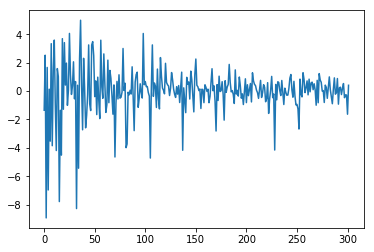

In [4]:
plt.plot(y)
plt.show()

In [5]:
n=len(y)
h0=0.0
u=np.mean(y)
phi=0.97
tau2=0.15**2
tau=np.sqrt(tau2)

In [6]:
h=[]
h.append(0)
for i in range(1,n):
    h.append(np.random.normal(u+phi*h[i-1],tau,1)[0])

In [34]:
#y=data5.T.values[0]

In [7]:
vol=np.exp(h)
sd=np.sqrt(vol)
ptr=[u,phi,tau]
h0tr=h0
htr=h
vtr=vol
sdtr=sd

In [8]:
theta0=[u,phi]
V0=np.eye(2)*100
nu0=10
s02=(nu0-2)/nu0*tau2
m0=h0
c0=100
M0=1000
M=3000

In [9]:
h0   = h0tr
h    = htr
mu   = ptr[0]
phi  = ptr[1]
tau2 = ptr[2]**2
vh   = 0.1

In [10]:
def svolrw(y,mu,phi,tau2,h0,h,vh):
    eta2=np.hstack((np.ones(n-1)*(tau2/(1+phi**2)),np.array([tau2])))
    eta=np.sqrt(eta2)
    coef1=((1-phi)/(1+phi**2))*mu
    coef2=(phi/(1+phi**2))
    for t in range(n-1):
        if t>=n-2:
            mut=mu+phi*h[t-1]
        elif t==0:
            mut=coef1+coef2*(h[2]+h[0])
        else:
            mut=coef1+coef2*(h[t+1]+h[t-1])
        ht=np.random.normal(h[t],vh,1)[0]
        num=norm.pdf(ht,mut,eta[t])*norm.pdf(y[t],0,np.exp(ht/2))
        den=norm.pdf(h[t],mut,eta[t])*norm.pdf(y[t],0,np.exp(h[t]/2))
        lacc=min(1,num/den)
        if np.random.uniform(0,1,1)[0]<lacc:
            h[t]=ht
    return h

In [11]:
def fixedpar(h,X,theta0,V0,nu0,s02):
    n=len(h)
    k=X.shape[1]
    par1=(nu0+n)/2
    var=(np.matrix(V0)**(-1)+np.matrix(X).T*np.matrix(X))**(-1)
    mean=var*((np.matrix(V0)**(-1))*np.matrix(theta0).T+np.matrix(X).T*np.matrix(h).T)
    par2=nu0*s02+(np.matrix(h).T-np.matrix(X)*mean).T*(np.matrix(h).T-np.matrix(X)*mean)
    par2=(par2+(mean-np.matrix(theta0).T).T*np.matrix(V0)**(-1)*(mean-np.matrix(theta0).T))/2
    sig2=1/np.random.gamma(par1,1/(par2.tolist()[0][0]),1)
    var=var*sig2[0]
    mean=mean+np.linalg.cholesky(var).T*np.matrix(np.random.randn(2)).T
    a=mean.tolist()
    a.append(list(sig2))
    return a

In [12]:
for iter in range(M0+M):
    h=svolrw(y,mu,phi,tau2,h0,h,vh)
    var=1/(1/c0+(phi**2)/tau2)
    mean=var*((1/c0)*m0+phi*(1/tau2)*(h[0]-mu))
    h0=np.random.normal(mean,np.sqrt(var),1)[0]
    X=np.vstack((np.ones(n),np.hstack((h0,h[0:n-1])))).T
    par=fixedpar(h,X,theta0,V0,nu0,s02)
    par=[par[0][0],par[1][0],par[2][0]]
    mu=par[0]
    phi=par[1]
    tau2=par[2]
    ps0=pd.DataFrame(par).T
    hs0=pd.DataFrame(h).T
    if iter==0:
        ps=ps0
        hs=hs0
    else:
        ps=ps.append(ps0)
        hs=hs.append(hs0)
ps.index=np.arange(M0+M)
hs.index=np.arange(M0+M)

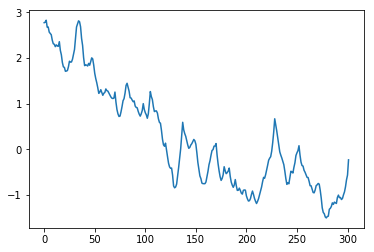

In [14]:
#plt.plot(hs[M0+M-1:M0+M].quantile(0.95))
#plt.plot(hs[M0+1:M0+M].quantile(0.5))
#plt.plot(hs[M0+1:M0+M].quantile(0.05))
plt.plot(hs[M0+1:M0+M].mean())
#plt.plot(pd.DataFrame(htr))
plt.show()

In [15]:
plt.figure(figsize=(20,18))
index=np.arange(0,9,3)
title=['mu','phi','tau2']
for idx in range(len(index)):
    plt.subplot(331+index[idx])
    plt.plot(ps[M0+1:M0+M][idx])
    plt.title(title[idx])
    plt.xlabel('iteration')
    plt.subplot(331+index[idx]+1)
    plt.hist(ps[M0+1:M0+M][idx])
    ax1=plt.subplot(331+index[idx]+2)
    sm.graphics.tsa.plot_acf(ps[M0+1:M0+M][idx],lags=40,ax=ax1)
    plt.xlabel('lag')

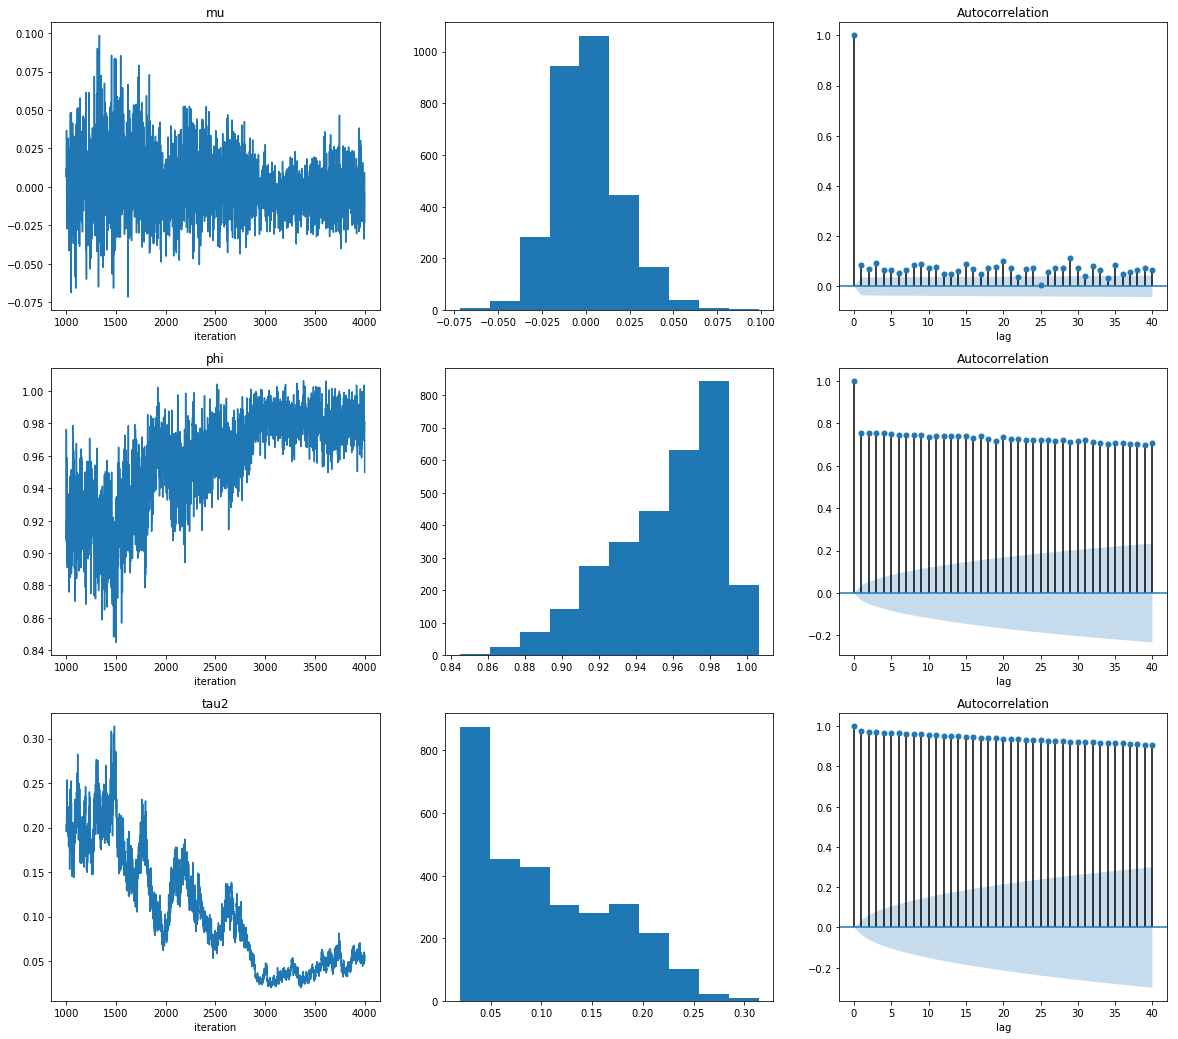

In [16]:
plt.show()

In [18]:
import csv
with open('C:\\Users\\wuboyuan\\Desktop\\结果\\random_h.csv', 'w') as f:
    #f.write(codecs.BOM_UTF8)
    writer = csv.writer(f,lineterminator='\n')
    writer.writerow(hs[M0+1:M0+M].T.index)
    writer.writerows(hs[M0+1:M0+M].values)

import csv
with open('C:\\Users\\wuboyuan\\Desktop\\结果\\random_theta.csv', 'w') as f:
    #f.write(codecs.BOM_UTF8)
    writer = csv.writer(f,lineterminator='\n')
    writer.writerow(ps[M0+1:M0+M].T.index)
    writer.writerows(ps[M0+1:M0+M].values)